
<img src="..\..\assets\maco7.png" align="left" style='width:1000px'/>
 
<br></br>
<br></br>
<br></br>
<br></br>
<br></br>

<h1>Tutorial : Data Statistics and Inspection </h1><hr style="border-width:2px;border-color:black">



<span>
Inspect and visualize data loading and pre-processing code:   
</span>
<ul>
    <li> Classes</li>
    <li> Class balance</li>
    <li> File extensions</li>
    <li> Image size</li>
    <li> Number of annotations per image</li>
    <li> Relative size of annotations</li>
    <li> Location of annotations</li>
    <li> Display samples</li>
</ul>

In [14]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

sys.path.append(ROOT_DIR)  # To find local version of the library
import src.mrcnn.utils as utils
import src.mrcnn.visualize
from src.mrcnn.visualize import display_images
import src.mrcnn.model as modellib
from src.mrcnn.config import Config
from src.mrcnn.model import log
import seaborn as sns
import pandas as pd
from src.mrcnn import visualize
from src.mrcnn.config_taco import TacoConfig, CocoLikeDataset

%matplotlib inline

## Load Dataset

In [2]:
config = TacoConfig()
TACO_DIR = os.path.join(ROOT_DIR, "datasets/taco_split")
json_path = os.path.join(TACO_DIR, "annotations/coco_annotations_train.json")
image_dir = os.path.join(TACO_DIR, "images/train")
dataset = CocoLikeDataset()
dataset.load_data(json_path, image_dir)
# Must call before using the dataset
dataset.prepare()
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Class Count: 8
  0. BG                                                
  1. plastic film                                      
  2. clear plastic bottle                              
  3. plastic bottle cap                                
  4. broken glass                                      
  5. drink can                                         
  6. cigarette                                         
  7. mask                                              


## Visualize class balance

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


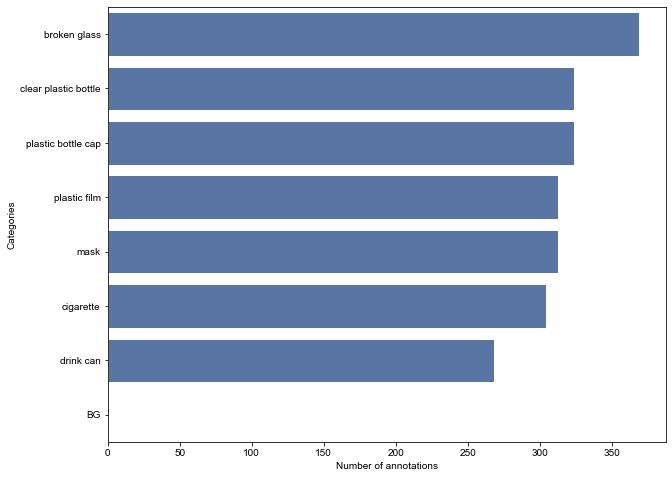

In [3]:
import pycocotools.coco
coco = pycocotools.coco.COCO(json_path)
# Count annotations
cat_histogram = np.zeros(dataset.num_classes,dtype=int)
class_names = []
for i, info in enumerate(dataset.class_info):
    ann_per_cat = coco.getAnnIds(catIds=i, iscrowd=None)
    cat_histogram[i] = len(ann_per_cat)
    class_names.append(info['name'])

# Initialize the matplotlib figure
_, ax = plt.subplots(figsize=(10,1*dataset.num_classes))

# Convert to DataFrame
d ={'Categories': class_names, 'Number of annotations': cat_histogram}
df = pd.DataFrame(d)
df = df.sort_values(by=['Number of annotations'], axis=0, ascending=False)

# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df,
            label="Total", color="b", orient="h")

fig = plot_1.get_figure()

      Number of files File extensions
JPEG              679            JPEG


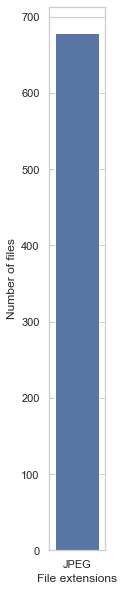

In [4]:
# Count file format
cat_histogram = np.zeros(dataset.num_classes,dtype=int)
file_extension = []
d = {}
for image_id in dataset.image_ids:
    file_format = dataset.image_info[image_id]['format']
    if (file_format in d.keys()):
        d[file_format] = d[file_format] + 1
    else:
        d[file_format] = 1

# Initialize the matplotlib figure
_, ax = plt.subplots(figsize=(1*len(d),10))

# Convert to DataFrame
# d ={'Extensions': extension, 'Number of annotations': cat_histogram}
df = pd.DataFrame.from_dict(d,orient='index',columns=["Number of files"])
df['File extensions'] = df.index
print(df)
# Plot the histogram
sns.set_color_codes("pastel")
sns.set(style="whitegrid")
plot_1 = sns.barplot(x='File extensions', y="Number of files", data=df,
            label="Total", color="b")

fig = plot_1.get_figure()

## Image stats
Before deciding your network configuration, it's a good idea look into the following statistics

### Image size

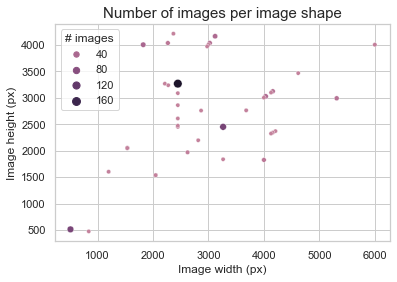

In [5]:
# Parsing image shapes (resolutions)
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}
for image_id in dataset.image_ids:
    img   = dataset.load_image(image_id)
    width = dataset.image_info[image_id]['width']
    height = dataset.image_info[image_id]['height']
    key = str(width)+'-'+str(height)
    if key in img_shapes_keys:
        shape_id = img_shapes_keys[key]
        shape_freqs[shape_id] += 1
    else:
        img_shapes_keys[key] = len(widths)
        widths.append(width)
        heights.append(height)
        shape_freqs.append(1)

d ={'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)
cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette = cmap,data=df)
plot = plot.set_title('Number of images per image shape',fontsize=15)

### Number of annotations per image

C:\Users\xllcr\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean number of annotations per image: 1.457236842105263


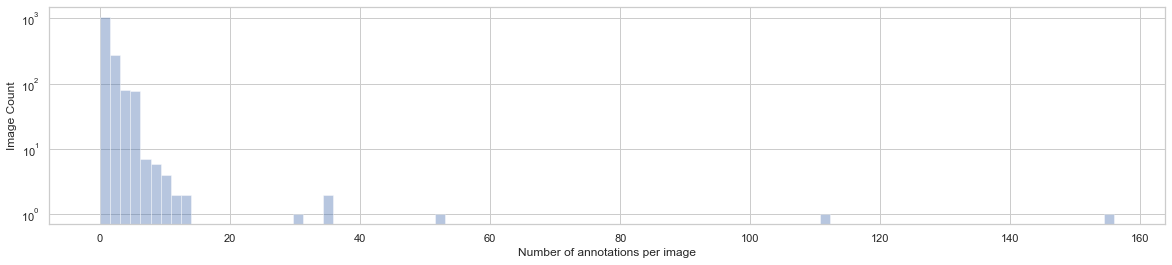

In [6]:
nr_annotation_per_image = []
for img in coco.dataset['images']:
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=[])
    nr_annotation_per_image.append(len(annIds))

plt.figure(figsize=(20,4))
ax = sns.distplot(nr_annotation_per_image,kde=False,bins=100)
ax.set_yscale('log')
ax.set(xlabel='Number of annotations per image', ylabel='Image Count')

print('Mean number of annotations per image:',np.mean(nr_annotation_per_image))

### Relative size of annotations

According to MS COCO Evaluation. This dataset has:
183 small objects (area<32*32 px)
561 medium objects (area<64*64 px)
862 large objects (area>96*96 px)


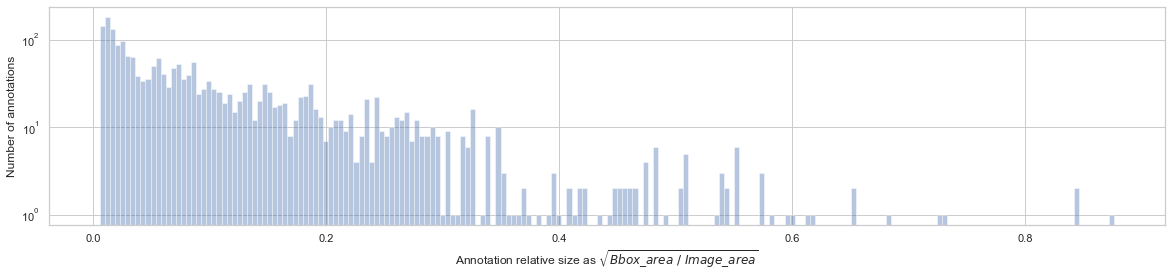

In [7]:
bbox_widths = []
bbox_heights = []
obj_areas_sqrt = []
obj_areas_sqrt_fraction = []
nr_small_objects = 0
for ann in coco.dataset['annotations']:
    bbox_widths.append(ann['bbox'][2])
    bbox_heights.append(ann['bbox'][3])
    obj_area = ann['bbox'][2]*ann['bbox'][3] # ann['area']
    obj_areas_sqrt.append(np.sqrt(obj_area))
        
    imgs = coco.loadImgs(ann['image_id'])
    img_area = imgs[0]['width']*imgs[0]['height']
    obj_areas_sqrt_fraction.append(np.sqrt(obj_area/img_area))
    
print('According to MS COCO Evaluation. This dataset has:')
print(np.sum(np.array(obj_areas_sqrt)<32), 'small objects (area<32*32 px)')
print(np.sum(np.array(obj_areas_sqrt)<64), 'medium objects (area<64*64 px)')
print(np.sum(np.array(obj_areas_sqrt)<96), 'large objects (area>96*96 px)')
    
# d ={'Bbox width (px)': bbox_widths, 'Bbox height (px)': bbox_heights, 'area': seg_areas}
# df = pd.DataFrame(d)

plt.figure(figsize=(20,4))
ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=200)
ax.set_yscale('log')
ax = ax.set(xlabel=r'Annotation relative size as $\sqrt{ Bbox\_area \ /  \ Image\_area}$', ylabel='Number of annotations')

# plt.figure(figsize=(20,4))
# plt.xlim(0,10) 
# ax = sns.distplot(obj_areas_sqrt_fraction,kde=False, bins=1000)

### Location of annotations

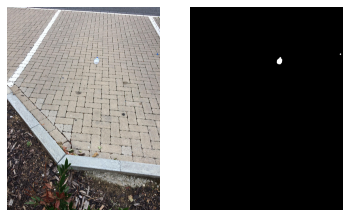

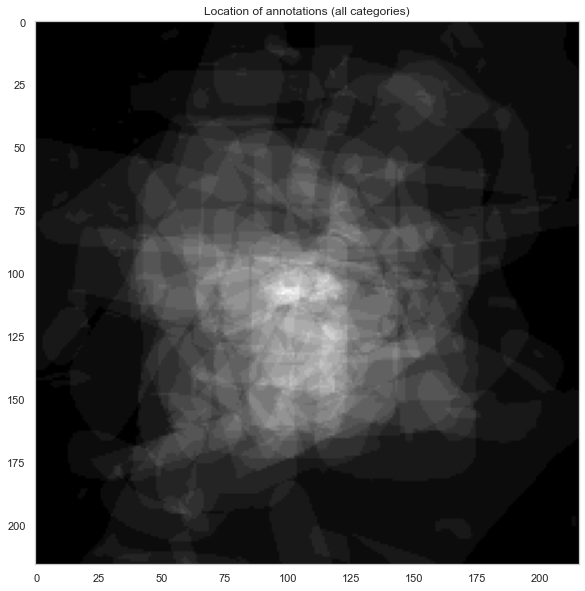

In [9]:
import cv2
img_tot_mask = np.zeros((216,216))
image_ids = np.random.choice(dataset.image_ids, min(100,len(dataset.image_ids)))
for i,image_id in enumerate(range(len(image_ids))):
    plt.subplot(1,2,1)
    # load image
    image = dataset.load_image(image_id)
    plt.imshow(image)
    plt.axis('off')
    # load mask
    mask, class_ids = dataset.load_mask(image_id)
    plt.subplot(1,2,2)
    mask = np.sum(mask, axis=-1)
    black_mask = np.where(mask>0., 1, 0)/255.
    plt.axis('off')
    plt.imshow(black_mask[:,:],cmap='gray')
    img_mask = cv2.resize(black_mask, (216, 216))
    img_tot_mask = img_tot_mask + img_mask
plt.figure(figsize=(10,10))
plt.title("Location of annotations (all categories)")
plt.imshow(img_tot_mask,cmap="gray")
plt.grid(False)

## Mask R-CNN configuration

In [10]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_SCORE_RATIO          True
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE        

## Data augmentation Demo

This may take some time, as we are working with the original image size...


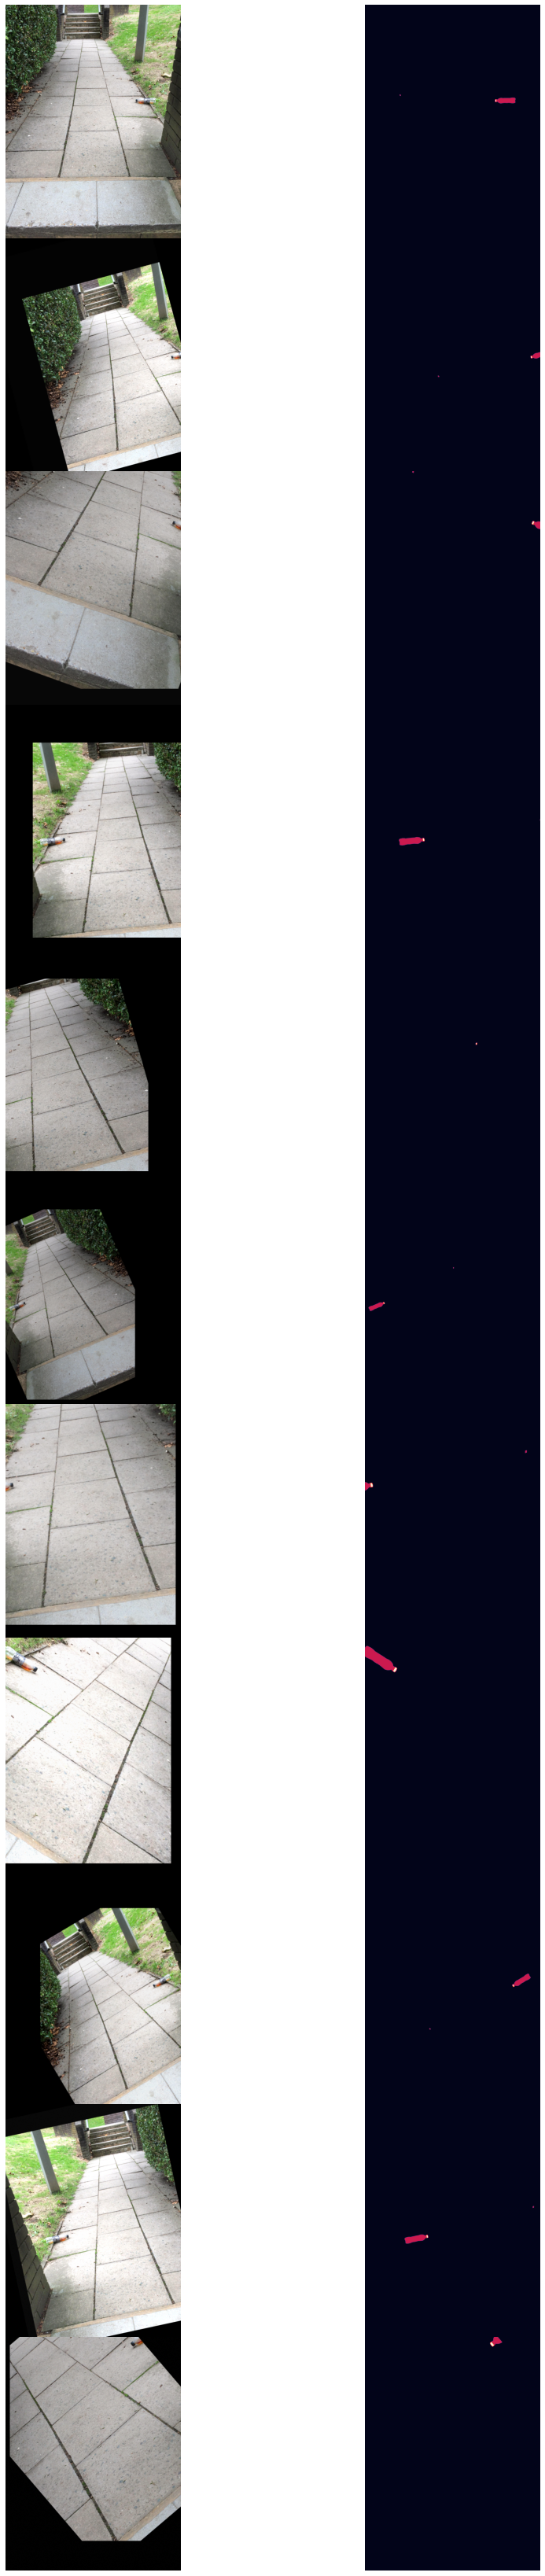

In [11]:
import imgaug as ia
from imgaug import augmenters as iaa
import imageio

#ia.seed(1)
nr_augmentations = 10

# Load random image
image_id = np.random.choice(len(dataset.image_ids))
image = dataset.load_image(image_id)
mask, _ = dataset.load_mask(image_id)

# Define our augmentation pipeline.
seq = iaa.Sequential([
        iaa.AdditiveGaussianNoise(scale=0.01 * 255, name="AWGN"),
        iaa.GaussianBlur(sigma=(0.0, 3.0), name="Blur"),
        # iaa.Dropout([0.0, 0.05], name='Dropout'), # drop 0-5% of all pixels
        iaa.Fliplr(0.5),
        iaa.Add((-20, 20),name="Add"),
        iaa.Multiply((0.8, 1.2), name="Multiply"),
        iaa.Affine(scale=(0.8, 2.0)),
        iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
        iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees
    ], random_order=True)

# Change activated augmentors for masks
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["Blur", "AWGN", "Add","Multiply"]:
        return False
    else:
        # default value for all other augmenters
        return default
    
hooks_masks = ia.HooksImages(activator=activator_masks)

# Initialize the matplotlib figure
fig, aux = plt.subplots(ncols=2, nrows=nr_augmentations+1, figsize=(15,60))

aux[0,0].imshow(image)
aux[0,0].axis('off')
aux[0,1].imshow(mask.sum(axis=2)) # form an unique segmask from multiple masks
aux[0,1].axis('off')

print('This may take some time, as we are working with the original image size...')

# Augment images and masks
for i in range(nr_augmentations):
    seq_det = seq.to_deterministic()
    image_augmented = seq_det.augment_image(image)
    mask_augmented = seq_det.augment_image(mask.astype(np.uint8), hooks=hooks_masks)
    seg_mask = mask_augmented.sum(axis=2)

    aux[i+1,0].imshow(image_augmented)
    aux[i+1,0].axis('off')
    aux[i+1,1].imshow(seg_mask)
    aux[i+1,1].axis('off')
    
    
plt.subplots_adjust(wspace=0.2, hspace=0)

## Display Samples

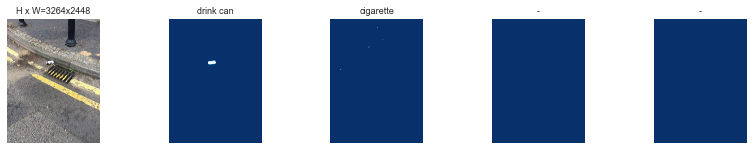

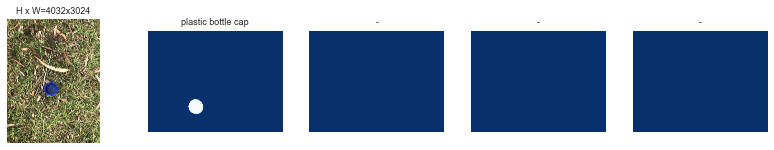

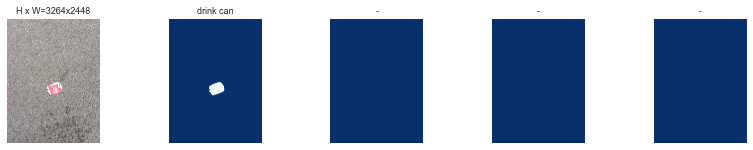

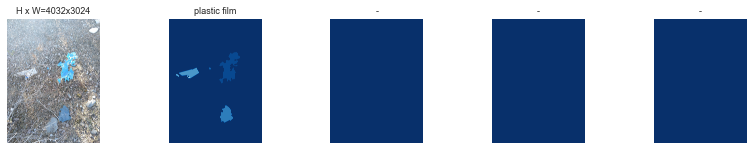

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding boxes

image_id  12 
image                    shape: (2448, 3264, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (2448, 3264, 2)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    6.00000  max:    6.00000  int32
bbox                     shape: (2, 4)                min:  740.00000  max: 2131.00000  int32


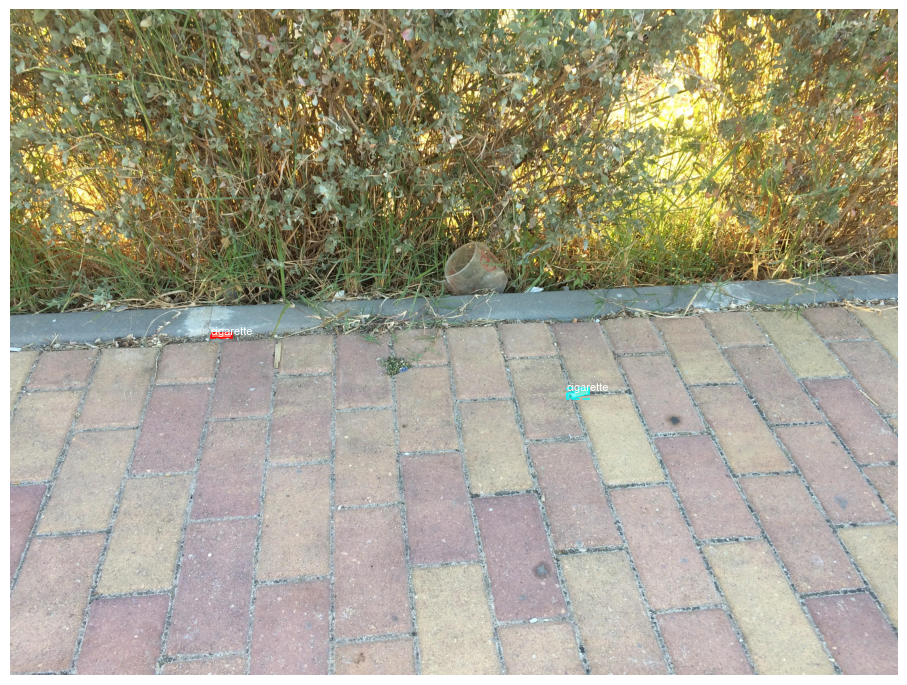

In [15]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)